# calculate events from Observational records of climate modes

In [1]:
import xarray
import pandas

#stuff to help with plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

In [3]:
nino3Domain=_index.sstIndex['nino3']

nino3Domain

{'latMin': -5, 'latMax': 5, 'longMin': 210, 'longMax': 270}

In [4]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino3Box={
    'xy':[nino3Domain['longMin']-mapCentre, nino3Domain['latMin']],
    'width':nino3Domain['longMax']-nino3Domain['longMin'],
    'height':nino3Domain['latMax']-nino3Domain['latMin']
}

nino3Box

{'xy': [0, -5], 'width': 60, 'height': 10}

In [5]:
nino4Domain=_index.sstIndex['nino4']

#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino4Box={
    'xy':[nino4Domain['longMin']-mapCentre, nino4Domain['latMin']],
    'width':nino4Domain['longMax']-nino4Domain['longMin'],
    'height':nino4Domain['latMax']-nino4Domain['latMin']
}

nino4Box

{'xy': [-50, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [6]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [7]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [8]:
sstClimat=sst.calculateClimatology(
    sstXr.sst.where(
        (sstXr.time.dt.year>=1971)
        *(sstXr.time.dt.year<=2000)
    )
)

In [9]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [10]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [11]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    nino3                   (year) float64 0.9921 -0.0506 ... -0.3786 -0.947
    westIONoDetrend         (year) float64 -0.3825 -0.3005 ... 0.9758 0.5053
    dmi                     (year) float64 -0.2179 -0.6161 ... 1.481 0.05624
    westIO                  (year) float64 -0.3615 -0.1887 ... 0.4602 0.1715
    eastIONoDetrend         (year) float64 -0.1646 0.3155 ... -0.5053 0.4491
    nino4                   (year) float64 0.4964 0.3311 ... 0.5096 -0.6466
    nino34NoDetrend         (year) float64 1.238 0.2379 ... 0.538 -0.7718
    backgroundSstNoDetrend  (year) float64 0.05152 -0.08729 ... 0.5706 0.2591
    eastIO                  (year) float64 -0.1437 0.4273 ... -1.021 0.1153
    nino4NoDetrend          (year) float64 0.5479 0.2438 ... 1.08 -0.3876
    nino34                  (year) float64 1.187 0.3252 ... -0.03262 -1.031

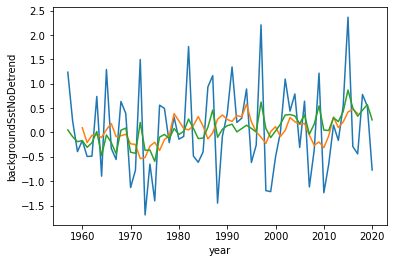

In [12]:
indexXr.nino34NoDetrend.plot()
indexXr.nino34NoDetrend.rolling(year=7,center=True).mean('year').plot()
indexXr.backgroundSstNoDetrend.plot()

In [13]:
varsToDetrend=[
    'dmi',
    'eastIO',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [14]:
#detrend
indexXr['dmiNoDetrend']=indexXr.dmi
            
for iVar in varsToDetrend:
    indexXr[iVar+'RollingDetrend']=(
        indexXr[iVar+'NoDetrend']
        -indexXr[iVar+'NoDetrend'].rolling(
            year=11,min_periods=5,center=True
        ).mean('year')
    )




In [15]:
# and EC index too
sstAnoms=ec.sstAnoms(
    sstXr.sst, 
    sstXr.sst.where(
        (sstXr.time.dt.year>=1971)
        *(sstXr.time.dt.year<=2000)
    )
)

sstAnoms.load()

#create the solver
solver=ec.eofSolver(
    sstAnoms.where(
        (sstAnoms.time.dt.year>=1971)
        *(sstAnoms.time.dt.year<=2000), 
        drop=True
    )
)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [16]:
std=pcXr.std()

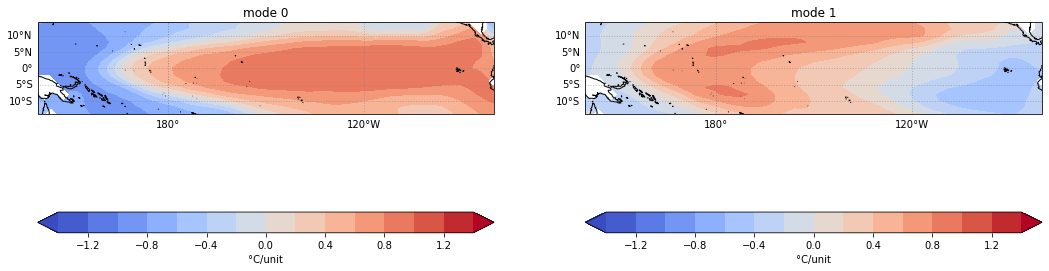

In [17]:
multiplyBy=[1,1]

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

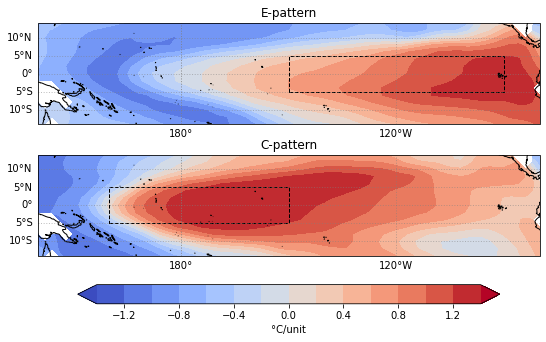

In [18]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino3Box['xy'], 
                width=nino3Box['width'], 
                height=nino3Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino4Box['xy'], 
                width=nino4Box['width'], 
                height=nino4Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.subplots_adjust(hspace=-0.3)
plt.savefig('figures/obsEvsCPattern.pdf')
plt.show()


In [19]:
fieldXr=solver.projectField(sstAnoms, neofs=2)

In [20]:
pcXr=xarray.Dataset()

In [21]:
pcXr['pc1']=fieldXr.sel(mode=0)
pcXr['pc2']=fieldXr.sel(mode=1)
pcXr=pcXr/std

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

In [22]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

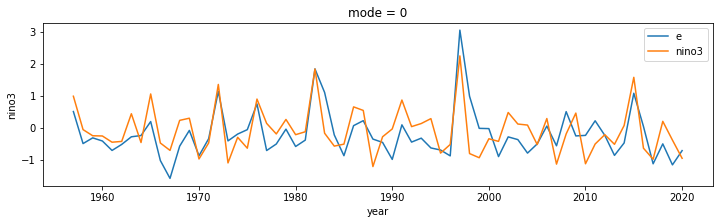

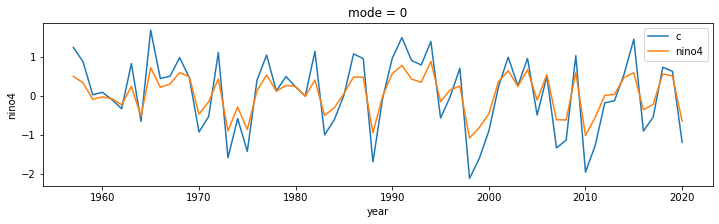

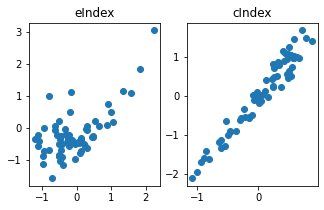

In [23]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.nino3.plot()
plt.legend(['e','nino3'])


#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.cIndex.plot()
indexXr.nino4.plot()

#plt.xlim([1950,2050])
plt.legend(['c','nino4'])

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino3, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino4, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [24]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [25]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28


In [26]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [27]:
indexXr['samSummer']=xarray.DataArray(
    (
        marshallXr.sel(
            year=range(1957,2021),
            month=['OCT','NOV','DEC']
        ).sum('month').values  #This is the sep to dec sum for each year
        + marshallXr.sel(
            year=range(1958,2022),
            month=['JAN','FEB','MAR']
        ).sum('month').values   #This is the jan feb sum for the next year
    )/6, 
    {'year':marshallXr.year.values[0:-1]}, 
    dims='year'
)

In [28]:
indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month')
)/6

In [29]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
    mode                    int64 0
Data variables: (12/21)
    nino3                   (year) float64 0.9921 -0.0506 ... -0.3786 -0.947
    westIONoDetrend         (year) float64 -0.3825 -0.3005 ... 0.9758 0.5053
    dmi                     (year) float64 -0.2179 -0.6161 ... 1.481 0.05624
    westIO                  (year) float64 -0.3615 -0.1887 ... 0.4602 0.1715
    eastIONoDetrend         (year) float64 -0.1646 0.3155 ... -0.5053 0.4491
    nino4                   (year) float64 0.4964 0.3311 ... 0.5096 -0.6466
    ...                      ...
    westIORollingDetrend    (year) float64 -0.0632 -0.0215 ... 0.2948 -0.2123
    nino4RollingDetrend     (year) float64 0.6324 0.2792 ... 0.4626 -0.9587
    cIndex                  (year) float64 1.236 0.8704 0.02594 ... 0.627 -1.188
    eIndex                  (year) float64 0.5134 -0.4873 ... -1.152 -0.707
    samSummer               (year) float64 -2.748 0.3033 1.265 ... -0.985 1.4
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.07833 -0.4883

In [30]:
#save them for use elsewhere

indexXr.to_netcdf('results/obsIndeces.nc')

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [6]:
indexXr=xarray.open_dataset('results/obsIndeces.nc')

In [7]:
stdXr=indexXr.sel(year=slice(1971,2000)).std()

In [18]:
criteriaXr=stdXr[['dmi','nino3','nino34','nino4', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2

In [19]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    mode       int64 ...
Data variables:
    dmi        float64 0.4346
    nino3      float64 0.8052
    nino34     float64 0.8016
    nino4      float64 0.5265
    eastIO     float64 0.3975
    eIndex     float64 0.8651
    cIndex     float64 1.012
    samWinter  float64 0.452
    samSummer  float64 0.4833

In [20]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['nino34', 'cIndex', 'samWinter', 'nino3', 'nino4', 'dmi', 'eIndex']
fireNeg: 
['eastIO', 'samSummer']


In [21]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [22]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [23]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 64)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
    mode        int64 0
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    cIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    nino3       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0
    nino4       (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    eIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 1.0 0.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    samSummer   (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 1.0 0.0 1.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 1.0 1.0

In [24]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [15]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

nino34 : [1957 1965 1972 1982 1986 1991 1997 2015]
cIndex : [1957 1965 1972 1977 1982 1986 1991 1994 2009 2015]
samWinter : [1967 1976 1979 1982 1989 1993 1997 1998 1999 2004 2010 2012 2015 2016
 2017]
nino3 : [1957 1965 1972 1976 1982 1991 1997 2015]
nino4 : [1965 1968 1977 1990 1991 1994 2002 2004 2006 2009 2015 2018]
dmi : [1961 1963 1967 1972 1994 1997 2006 2012 2015 2018 2019]
eIndex : [1972 1982 1983 1997 1998 2015]
eastIO : [1961 1963 1967 1972 1994 1997 2006 2019]
samSummer : [1957 1964 1966 1968 1971 1974 1976 1979 1982 2002 2016 2019]
ecCombined : [1957 1965 1972 1977 1982 1983 1986 1991 1994 1997 1998 2009 2015]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (ok, not great)


In [16]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='neg')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

nino34 : [1973 1975 1988 1998 1999 2007 2010 2020]
cIndex : [1973 1975 1988 1998 1999 2007 2008 2010 2011 2020]
samWinter : [1964 1972 1981 1988 1990 1996 2007]
nino3 : [1970 1973 1988 1999 2007 2010 2017 2020]
nino4 : [1964 1973 1975 1988 1998 1999 2007 2008 2010 2011 2020]
dmi : [1958 1960 1981 1990 1992 1996 1998 2005 2010 2016]
eIndex : [1966 1967 1970 1985 1990 1996 2001 2017 2019]
eastIO : [1958 1960 1975 1988 1992 1998 2005 2010 2016]
samSummer : [1959 1961 1973 1981 1993 1998 1999 2007 2008 2010 2014 2015 2017 2018
 2020]
ecCombined : [1966 1967 1970 1973 1975 1985 1988 1990 1996 1998 1999 2001 2007 2008
 2010 2011 2017 2019 2020]


# Check events against the initial SSTs:

In [17]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

NameError: name 'sstXr' is not defined

In [ ]:
%run helpers/impactPlots.ipynb

In [ ]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)